Using the Yeast Dataset, where each instance corresponds to an experiment and the features represent gene expression levels, the objective is to predict a set of 14 possible functional categories (multi-label classification). Despite being standardized, the dataset may still present data veracity challenges, such as:

Noisy or Ambiguous Labels: Genes that belong to multiple functional categories or have been incorrectly annotated.

Outliers: Experiments showing atypical or extreme gene expression patterns.

Hard-to-Learn Samples: Instances located in regions where multiple functional categories overlap, making classification difficult.

To visualize and better understand these data quality concerns—and the resulting challenges for classification—techniques like t-SNE and Isomap can be applied to the feature vectors.

In [2]:
import pandas as pd
from scipy.io import arff
import os
import zipfile

# Unzip yeast.rar (already uploaded to Colab as 'yeast.rar')
!unrar x yeast.rar


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from yeast.rar

Extracting  yeast.arff                                                     2%  4%  6%  8% 10% 12% 14% 16% 18% 20% 22% 24% 26% 28% 30% 32% 34% 36% 38% 40% 42% 44% 46% 48% 49%  OK 
Extracting  yeast.xml                                                     49%  OK 
Extracting  yeast-test.arff                                               51% 53% 55% 57% 59% 61% 63% 65% 67% 68%  OK 
Extracting  yeast-train.arff                                              70% 72% 74% 76% 78% 80% 82% 84% 86% 88% 90% 92% 94% 96% 98%100%  OK 
All OK


Initially inspecting and analysing the MULAN Dataset

In [3]:
# Find the .arff file (e.g., 'yeast-train.arff' or 'yeast.arff')
arff_path = "yeast.arff"
# Load ARFF file into pandas DataFrame
data, meta = arff.loadarff(arff_path)
df = pd.DataFrame(data)

# Check all columns
print(df.columns)

# Identify label columns (from the associated XML, or based on last 14 columns)
X = df.iloc[:, :-14]  # First 86 columns: features
Y = df.iloc[:, -14:]  # Last 14 columns: labels

print("Feature matrix X shape:", X.shape)
print("Target matrix Y shape:", Y.shape)
print("Number of data points:", df.shape[0])
print("Number of features:", X.shape[1])
print("Number of labels:", Y.shape[1])

Index(['Att1', 'Att2', 'Att3', 'Att4', 'Att5', 'Att6', 'Att7', 'Att8', 'Att9',
       'Att10',
       ...
       'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10', 'Class11',
       'Class12', 'Class13', 'Class14'],
      dtype='object', length=117)
Feature matrix X shape: (2417, 103)
Target matrix Y shape: (2417, 14)
Number of data points: 2417
Number of features: 103
Number of labels: 14


In [4]:
print(df.head(1))

       Att1      Att2      Att3      Att4      Att5      Att6      Att7  \
0  0.004168 -0.170975 -0.156748 -0.142151  0.058781  0.026851  0.197719   

      Att8      Att9     Att10  ...  Class5  Class6  Class7  Class8  Class9  \
0  0.04185  0.066938 -0.056617  ...    b'0'    b'0'    b'1'    b'1'    b'0'   

   Class10  Class11  Class12  Class13  Class14  
0     b'0'     b'0'     b'1'     b'1'     b'0'  

[1 rows x 117 columns]


### Dataset Summary

- **Number of data points (samples):** 2417  
- **Number of features:** 103  
- **Feature names:** Att1, Att2, …, Att10, … (total 103)  
- **Number of labels (targets):** 14  
- **Label names:** Class1, Class2, …, Class14  
- **Feature matrix shape (`X`):** (2417, 103)  
- **Target matrix shape (`Y`):** (2417, 14)


1. **Convert Labels to Numeric (0/1)**
   - All target labels are converted to numeric form (`0` for absence, `1` for presence) using `Y_numeric`.
   - This facilitates counting and manipulation of labels.

2. **Identify Active Labels for Each Sample**
   - Each row (sample) is converted into a tuple of active label names.
   - This allows distinction between **single-label samples** and **multi-label samples**.

3. **Single-Label and Multi-Label Counts**
   - **Single-label counts:** Frequency of each label among rows that have exactly one label.
   - **Multi-label combinations:** Frequency of each combination of labels that appear together.
   - **Output:** Frequencies of all single-label classes are printed.

4. **Top Categories Identification**
   - **Top 2 single-labels:** The two most frequent single-label classes.
   - **Top multi-label combination:** The most frequent combination among multi-label samples.
   - These top categories are used for visualization purposes.

5. **Assign Simplified Visualization Categories**
   - Each sample is assigned one of the following:
     - `"Top_Single_1"` → sample has the most frequent single label.
     - `"Top_Single_2-"` → sample has the second most frequent single label.
     - `"Top_Multi_Combo"` → sample matches the most frequent multi-label combination.
     - `"Other"` → all other samples (less frequent single labels or other multi-label combinations).


This preprocessing allows effective **color-coding and grouping of samples** in subsequent dimensionality reduction plots (e.g., t-SNE, Isomap).

In [5]:
from collections import Counter
# Convert labels to numeric (0/1)
Y_numeric = Y.apply(pd.to_numeric, errors='coerce')
# ------------------------------
# Step 1: Convert each row into active label names
# ------------------------------
label_sets = [tuple(row[row == 1].index) for _, row in Y_numeric.iterrows()]

# ------------------------------
# Step 2: Count single-labels and multi-label combos
# ------------------------------
single_counts = Counter([ls[0] for ls in label_sets if len(ls) == 1])
combo_counts = Counter([ls for ls in label_sets if len(ls) >= 2])

# Frequencies of all single-label classes
print("Frequencies of ALL single-label classes:")
for label, freq in single_counts.most_common():
    print(f"{label}: {freq}")

# Identify top 2 single-labels and top multi-label combo
top_single = [lbl for lbl, _ in single_counts.most_common(2)]
top_combo = combo_counts.most_common(1)[0][0] if len(combo_counts) > 0 else tuple()

print("\nTop 2 single-labels:", top_single)
print("Top multi-label combo:", top_combo)

# ------------------------------
# Step 3: Assign simplified visualization categories
# ------------------------------
def categorize_labels(active_labels):
    if len(active_labels) == 1 and active_labels[0] == top_single[0]:
        return "Top_Single_1"
    if len(active_labels) == 1 and len(top_single) > 1 and active_labels[0] == top_single[1]:
        return "Top_Single_2"
    # Multi-label rows are considered "Other" unless they match top combo
    if len(active_labels) >= 2 and active_labels == top_combo:
        return "Top_Multi_Combo"
    return "Other"

viz_labels = pd.Series([categorize_labels(ls) for ls in label_sets], name="viz_class")

print("\nSimplified label distribution:")
print(viz_labels.value_counts())


Frequencies of ALL single-label classes:
Class1: 32

Top 2 single-labels: ['Class1']
Top multi-label combo: ('Class3', 'Class4', 'Class12', 'Class13')

Simplified label distribution:
viz_class
Other              2148
Top_Multi_Combo     237
Top_Single_1         32
Name: count, dtype: int64


From the above, it is evident that the rows that have single class labels only belong to Class 1 and there are 32 of them. The top combo is the combo : (0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0)

### Feature Scaling (Standardization) for Distance-Based Methods

**Purpose of Scaling:**
- Distance-based dimensionality reduction techniques (e.g., t-SNE, Isomap, PCA) rely on computing distances between samples in high-dimensional space.
- If features have different numeric ranges, features with larger scales dominate the distance computations leading to biased embeddings and distorted neighborhood structures. Proper feature scaling is essential to ensure meaningful and reliable visualizations.
- **Standardization** ensures that all features contribute equally by transforming them to have:
  - **Mean ≈ 0**
  - **Standard deviation ≈ 1**

In [6]:
from sklearn.preprocessing import StandardScaler

# Standardize feature matrix X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Check mean and std of first 5 features
print("Scaled features mean (approx):", X_scaled[:, :5].mean(axis=0))
print("Scaled features std (approx):", X_scaled[:, :5].std(axis=0))


Scaled features mean (approx): [ 1.98434566e-17 -8.81931406e-18 -7.34942838e-18  1.02891997e-17
 -1.76386281e-17]
Scaled features std (approx): [1. 1. 1. 1. 1.]


### t-SNE (t-Distributed Stochastic Neighbor Embedding) Implementation and Visualization

**Purpose:**
- t-SNE is a **non-linear dimensionality reduction technique** that maps high-dimensional data to a low-dimensional space (usually 2D or 3D) while preserving the **local structure** of the data.
- Unlike PCA, which preserves **global variance**, t-SNE focuses on keeping **similar points close together** in the embedding.

**Mathematical Intuition:**
1. For each pair of points in the high-dimensional space, t-SNE computes a **similarity probability**:
   \[$
   p_{j|i} = \frac{\exp(-||x_i - x_j||^2 / 2\sigma_i^2)}{\sum_{k \neq i} \exp(-||x_i - x_k||^2 / 2\sigma_i^2)}
   $\]
   where \($\sigma_i$\) is set according to a **perplexity** parameter, controlling the neighborhood size.
2. In the low-dimensional space, t-SNE defines a similar probability distribution using a **Student’s t-distribution**:
   \[$
   q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l} (1 + ||y_k - y_l||^2)^{-1}}
   $\]
3. The algorithm minimizes the **Kullback-Leibler (KL) divergence** between the high-dimensional and low-dimensional distributions:
   \[$
   KL(P||Q) = \sum_i \sum_j p_{ij} \log \frac{p_{ij}}{q_{ij}}
   $\]
   - This ensures that points that are close in high-dimensional space remain close in 2D/3D.


Running t-SNE with perplexity=5 ...
Running t-SNE with perplexity=15 ...
Running t-SNE with perplexity=25 ...
Running t-SNE with perplexity=35 ...
Running t-SNE with perplexity=45 ...
Running t-SNE with perplexity=55 ...


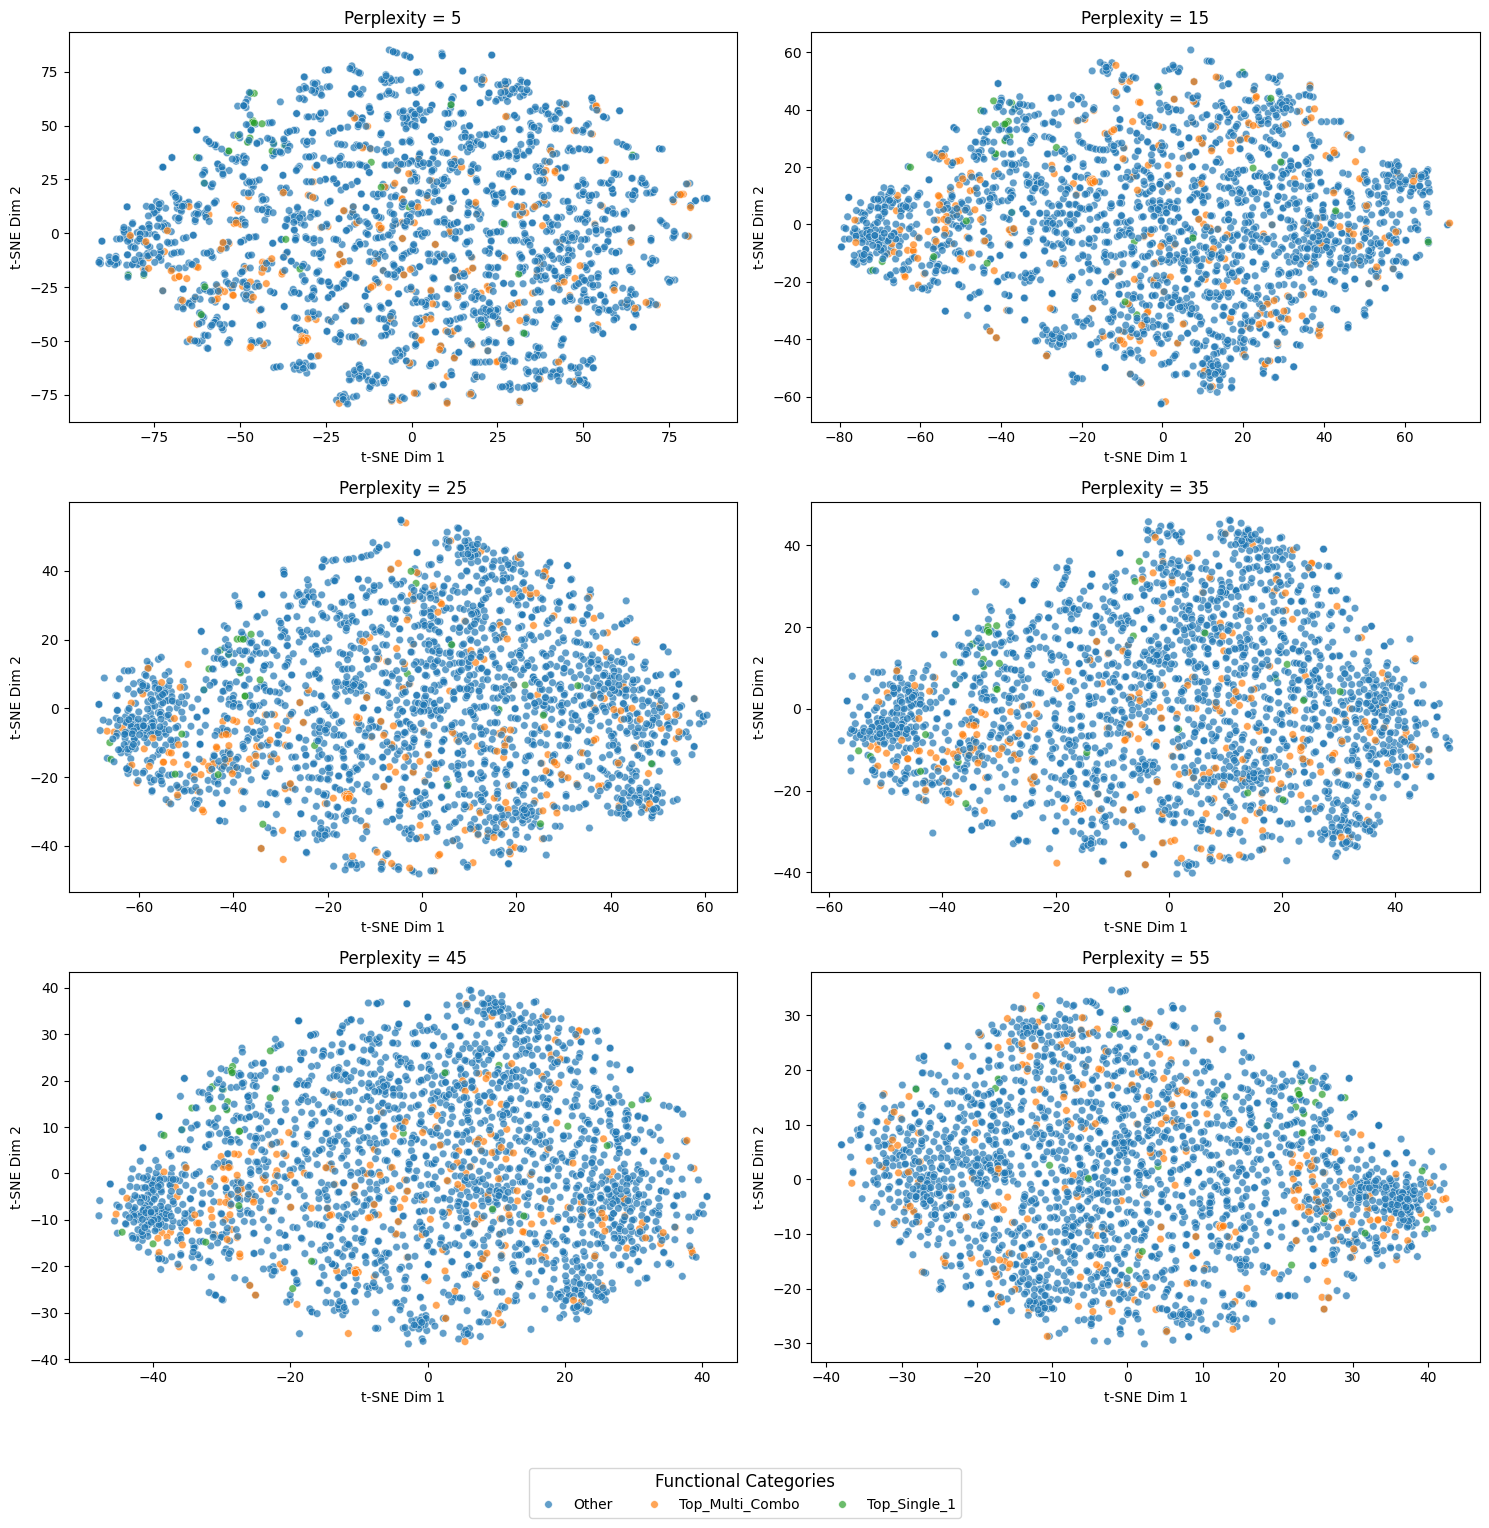

In [11]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert labels if needed
labels_to_plot = np.array(viz_labels)

# Define perplexity values
perplexities = range(5, 60, 10)
tsne_results = {}

# Compute t-SNE for each perplexity
for perp in perplexities:
    print(f"Running t-SNE with perplexity={perp} ...")
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[perp] = X_tsne

# Setup subplots
n_plots = len(perplexities)
n_rows = (n_plots + 1) // 2  # 2 columns
n_cols = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Define consistent color palette
unique_labels = np.unique(labels_to_plot)
palette = sns.color_palette("tab10", n_colors=len(unique_labels))

# Store scatter for legend extraction
scatter_for_legend = None

# Plot all t-SNE embeddings
for idx, perp in enumerate(perplexities):
    X_tsne = tsne_results[perp]
    ax = axes[idx]
    scatter = sns.scatterplot(
        x=X_tsne[:, 0], y=X_tsne[:, 1],
        hue=labels_to_plot,
        palette=palette,
        s=30,
        alpha=0.7,
        ax=ax,
        legend='full'
    )
    ax.set_title(f"Perplexity = {perp}")
    ax.set_xlabel("t-SNE Dim 1")
    ax.set_ylabel("t-SNE Dim 2")

    if scatter_for_legend is None:
        scatter_for_legend = scatter  # Save for legend extraction

    ax.legend_.remove()  # Remove subplot legends for clarity

# Create a single shared legend
handles, labels = scatter_for_legend.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.02),
    ncol=max(1, min(4, len(labels))),
    title="Functional Categories",
    frameon=True,
    fontsize='medium',
    title_fontsize='large'
)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # Space for legend at bottom
plt.show()


**Why Experiment with Perplexity?**
- **Perplexity** is a key hyperparameter in t-SNE that roughly corresponds to the **effective number of nearest neighbors** considered for each point.
- Small perplexity (e.g., 5) focuses on very local structure and may split clusters into smaller fragments.
- Large perplexity (e.g., 50) considers a broader neighborhood, preserving more global structure but may blur fine cluster details.
- Exploring a **range of perplexities** (5 to 50 in steps of 5) allows us to see how cluster separation and structure change and helps identify the value that gives the most meaningful visualization.

Perplexity = 5, 15: clusters are loose and more scattered. Some points look isolated.

Perplexity = 25, 35: clusters start to separate well while preserving local structure.

Perplexity = 45, 55: clusters are compressed and some local details may be lost. overall global structures maintained.

##Recommended perplexity:
25-35 for visual clarity while keeping cluster distinctions.

# t-SNE Plot Analysis


## Overall:
Each dot represents one sample from the dataset.
Colors correspond to the simplified label:
Other (blue): samples not in the most common classes/combo.
Most-freq-multi (orange): samples with the most common multi-label combination.
Single:Class1 (green): samples with the most frequent single-label.
Spatial arrangement reflects how similar samples are to each other according to t-SNE: similar points are plotted closer together.

### Noisy / Ambiguous Labels
**Definition:** Points whose color is deeply embedded inside a cluster of a different color.  
**Observation:**  
- Blue points inside green clusters, or orange points inside blue clusters. In the plot we can see a lot of orange points and green points scattered through the blue regions.
- Could represent mislabels or cells/samples with mixed characteristics.  


---

### Outliers
**Definition:** Isolated points or tiny clusters far from main clusters.  
**Observation:**  
- Look at the edges of the t-SNE plot.  
- Example: single green or orange points away from main clusters.  
**Hypothesis:** Rare cell types, experimental noise, or measurement artifacts. They could warrant additional inspection or potential exclusion from further analysis.

---

### Hard-to-Learn Samples
**Definition:** Areas where colors are thoroughly mixed → classifier may struggle.  
**Observation:**  
- Overlapping regions of blue, orange, and green in the center of clusters.  
- Feature values too similar for a simple classifier to separate.  
- Could correspond to intermediate states or cells with ambiguous expression profiles. In these areas, no simple linear or even nonlinear classifier can reliably draw a separation.

---

### Summary Table

| Feature               | Visual Cue                             | Interpretation                                |
|-----------------------|----------------------------------------|-----------------------------------------------|
| Noisy / Ambiguous     | Points embedded in clusters of other colors | Possible mislabels or mixed phenotypes       |
| Outliers              | Isolated points far from main clusters | Rare types, experimental noise                |
| Hard-to-Learn Samples | Dense color mixing                     | Similar expression profiles, classifier confusion |


#ISOMAP

**Objective:**
- Apply **Isomap**, a nonlinear dimensionality reduction technique, to reduce the high-dimensional feature matrix `X_scaled` to 2 dimensions.
- Visualize the resulting 2D embedding, coloring points according to the simplified categories (`viz_labels`) created in Part A.

**Why Isomap?**
- Isomap is a **manifold learning method** that preserves the **global geometric structure** of the data.
- It computes a **graph of nearest neighbors** and estimates **geodesic distances** (shortest paths along the manifold) between all pairs of points.
- This contrasts with **t-SNE**, which preserves primarily **local neighborhood structure** but can distort global distances and cluster sizes.

**Key Difference Between Isomap and t-SNE:**

Isomap preserves the global structure of the data by maintaining geodesic (shortest path along the manifold) distances between all points. It builds a neighborhood graph, computes shortest paths, and then embeds the data so that these global relationships are retained in the lower-dimensional space.

t-SNE focuses on preserving the local structure—it models pairwise similarities so that points that are close in high-dimensional space remain close in the embedding. However, t-SNE does not reliably preserve global relationships; distances between clusters or far-apart points may be distorted

| Aspect               | Isomap                        | t-SNE                        |
|----------------------|-------------------------------|------------------------------|
| Focus                | Global structure              | Local neighborhoods          |
| Distance preservation | Geodesic distances along manifold | Pairwise similarities (probabilities) |
| Cluster sizes         | Meaningful relative distances | May be distorted             |
| Use case              | Visualizing overall geometry  | Exploring local cluster structure |
|Drawbacks	            |Can stretch or merge local details	| Can split clusters or mislead about global distances

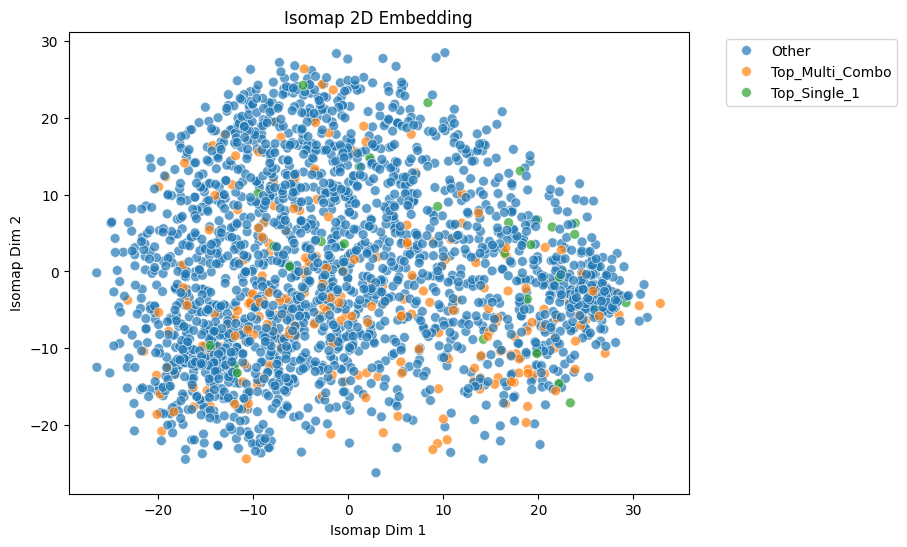

In [9]:
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt
import seaborn as sns

# Apply Isomap to scaled feature matrix
isomap = Isomap(n_components=2, n_neighbors=5)  # n_neighbors can be tuned
X_isomap = isomap.fit_transform(X_scaled)


plt.figure(figsize=(8,6))
sns.scatterplot(
    x=X_isomap[:,0], y=X_isomap[:,1],
    hue=viz_labels,
    palette="tab10",
    s=50,
    alpha=0.7
)
plt.title("Isomap 2D Embedding")
plt.xlabel("Isomap Dim 1")
plt.ylabel("Isomap Dim 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()



### Summary of Isomap 2D Embedding

**Overall structure**  
- The data is spread fairly continuously across the 2D space without forming very sharp, isolated clusters.  
- This suggests that the gene expression data may lie on a **smooth, curved manifold** rather than being divided into completely separate groups.  

**Distribution of categories**  
- **Blue (Other):** Dominates the space and is widely spread, indicating that most samples are broadly distributed across the manifold.  
- **Orange (Top_Multi_Combo):** Points appear scattered throughout the manifold, but there are **denser pockets** in certain regions — suggesting that these combinations have some structure and group together in parts of the space.  
- **Green (Top_Single_1):** Fewer in number, scattered but not isolated, suggesting that they don’t form a single tight cluster but instead **overlap partially** with both "Other" and "TopCombo".  

**Global structure captured**  
- Unlike **t-SNE**, which often pulls out small tight clusters, **Isomap** maintains the **global geometry** — you can see how all points fit into one continuous shape.  
- This indicates that there may be **gradients or smooth transitions** in gene expression patterns, rather than sharply separated subtypes.

**Overall:**
Isomap is better at revealing the global structure of gene expression data, as it preserves the spatial relationships between all groups, not just the closest points.
t-SNE produces sharper local clusters, but these may reflect local groupings more than the real overall map of the data in high dimensions.


### Comparison and Curvature Analysis

**Concept of a Data Manifold:**
- In high-dimensional datasets, **data points often lie on a lower-dimensional manifold** embedded in the high-dimensional space.
- A **manifold** is a smooth surface that locally resembles Euclidean space but may have global curvature or twists.
- Dimensionality reduction methods like **Isomap** aim to uncover this underlying manifold structure while preserving distances along it.

**Observations from Isomap Plot:**
- The Isomap 2D embedding shows how samples are distributed along the **global manifold**.
- If points are stretched, curved, or form complex non-linear shapes, this indicates a **highly curved or complex manifold**.
- Conversely, if points lie mostly in simple clusters with roughly linear separations, the manifold is relatively flat.

**Implications for Classification:**
- **Highly curved or complex manifolds** mean that simple linear classifiers (e.g., logistic regression, linear SVM) may struggle, as the decision boundaries are not straight.
- Complex manifolds often require **non-linear classifiers** (e.g., kernel SVM, neural networks) to capture the true class boundaries.
- Understanding manifold complexity helps guide **model choice** and informs the design of dimensionality reduction for visualization or preprocessing.

**Summary Insight:**
- The Isomap visualization provides intuition about the **geometric structure of the dataset**.
- The degree of curvature and complexity in the embedding correlates with **classification difficulty**, especially for distinguishing overlapping or entangled classes on the manifold by just using linear methods